In [ ]:
import requests
import csv
from datetime import datetime
import time

API_KEY = 'API_KEY'

SEARCH_QUERIES = [
    "polusi udara jakarta", "kualitas udara jakarta", "cuaca jakarta",
    "banjir jakarta", "debu jakarta", "asap jakarta", "kabut jakarta",
    "hujan jakarta", "banjir jkt", "polusi jkt"
]

VIDEO_IDS_MANUAL = [
    "Xmd_6ZXl6lI","imlCPA5Vu2c","OGw2Jhu4KlU","fZU9Q1_GHLE",
    "kJsBTQkZV0M","Mp4hDSnpjQ4","_41KtEUiZT8","E4nuMUg96aM",
    "frPoXlkkOXM","zdhm5OuH5Qs","52BE41TcHu4","bnb8RHwortQ"
]

COMMENT_KEYWORDS = [
    "banjir","cuaca","polusi","polusi udara","debu","asap","kabut",
    "kualitas udara","hujan","angin","kotor","pabrik","abu","jkt",
    "jakarta","sungai"
]

COMMENT_KEYWORDS = [k.lower() for k in COMMENT_KEYWORDS]


def safe_get(url, params, max_retries=3, backoff=2):
    for attempt in range(max_retries):
        try:
            r = requests.get(url, params=params, timeout=20)
            if r.status_code == 200:
                return r.json()
            else:
                print(f"HTTP {r.status_code} - {r.text[:200]}")
                # if quota or forbidden, break early
                if r.status_code in (403, 400):
                    return {"error": f"HTTP {r.status_code}"}
        except Exception as e:
            print("Request error:", e)
        time.sleep(backoff * (attempt + 1))
    return {"error": "max retries"}

def search_videos(query, max_results=25):
    url = "https://www.googleapis.com/youtube/v3/search"
    params = {
        "key": API_KEY,
        "q": query,
        "part": "id",
        "maxResults": max_results,
        "type": "video"
    }
    data = safe_get(url, params)
    ids = []
    if "items" in data:
        for it in data["items"]:
            vid = it.get("id", {}).get("videoId")
            if vid:
                ids.append(vid)
    else:
        print("Search error or no items for query:", query, data.get("error"))
    return ids

def scrape_comments_for_video(video_id):
    url = "https://www.googleapis.com/youtube/v3/commentThreads"
    results = []
    page_token = None
    checked = 0
    matched = 0

    while True:
        params = {
            "key": API_KEY,
            "part": "snippet",
            "videoId": video_id,
            "maxResults": 100,
            "textFormat": "plainText"
        }
        if page_token:
            params["pageToken"] = page_token

        data = safe_get(url, params)
        if "error" in data:
            print("API error while fetching comments for", video_id, data.get("error"))
            break

        items = data.get("items", [])
        if not items and page_token is None:
            print(f"-> No commentThreads returned for video {video_id} (comments may be disabled or none).")
            break

        for it in items:
            try:
                c = it["snippet"]["topLevelComment"]["snippet"]
            except Exception:
                continue
            checked += 1
            text = c.get("textDisplay", "")
            text_l = text.lower()
            published = c.get("publishedAt")

            dt = None
            if published:
                try:
                    dt = datetime.fromisoformat(published.replace("Z", "+00:00"))
                except Exception:
                    try:
                        dt = datetime.strptime(published, "%Y-%m-%dT%H:%M:%S.%fZ")
                    except Exception:
                        dt = None

            if dt and dt.year == 2023 and any(kw in text_l for kw in COMMENT_KEYWORDS):
                matched += 1
                results.append({
                    "tanggal": dt.strftime("%Y-%m-%d"),
                    "komentar": text,
                    "video_id": video_id
                })

        page_token = data.get("nextPageToken")
        if not page_token:
            break

    return results, checked, matched

video_ids = set(VIDEO_IDS_MANUAL)

print("Searching videos from queries...")
for q in SEARCH_QUERIES:
    found = search_videos(q, max_results=25)
    for v in found:
        video_ids.add(v)

video_ids = list(video_ids)
print("Total videos to check:", len(video_ids))

all_rows = []
summary = []

for vid in video_ids:
    print("\n--- Processing video:", vid)
    rows, checked, matched = scrape_comments_for_video(vid)
    print(f"Checked comments: {checked}, Matched: {matched} for video {vid}")
    all_rows.extend(rows)
    summary.append({"video_id": vid, "checked": checked, "matched": matched})

outfile = "data/komentar_jakarta_2023_debug.csv"
if all_rows:
    with open(outfile, "w", newline="", encoding="utf-8-sig") as f:
        writer = csv.DictWriter(f, fieldnames=["tanggal", "komentar", "video_id"])
        writer.writeheader()
        writer.writerows(all_rows)
    print(f"\nSelesai. Disimpan: {outfile}. Total matched rows: {len(all_rows)}")
else:
    print("\nTidak ditemukan komentar yang cocok di semua video (hasil matched = 0).")
    print("Ringkasan per video (checked, matched):")
    for s in summary:
        print(f" - {s['video_id']}: checked={s['checked']}, matched={s['matched']}")


SCRAPING COMENTAR YOUTUBE TENTANG RESPON PUBLIK TERHADAP CUACA DAN KUALITAS UDARA

Cleaning hasil scraping sentimen 

In [3]:
import pandas as pd
import re

data = pd.read_csv("data/komentar_jakarta_2023_debug.csv")

data = data.dropna(how="all")

def bersihkan_komentar(teks):
    if pd.isna(teks):
        return ""
    teks = str(teks).strip()

    teks = re.sub(r"[^a-zA-Z0-9.,!?()/%\- ]+", " ", teks)

    teks = re.sub(r"\s+", " ", teks)

    return teks.strip()


data["komentar"] = data["komentar"].apply(bersihkan_komentar)

data = data[data["komentar"] != ""]

data = data.drop_duplicates(subset=["tanggal", "komentar"])

kelompok_tanggal = data.groupby("tanggal")["komentar"].apply(list).reset_index()


maksimal_isi = kelompok_tanggal["komentar"].apply(len).max()

for i in range(maksimal_isi):
    kelompok_tanggal[f"sentimen_{i+1}"] = kelompok_tanggal["komentar"].apply(
        lambda daftar: daftar[i] if i < len(daftar) else ""
    )

kelompok_tanggal = kelompok_tanggal.drop(columns=["komentar"])
display(kelompok_tanggal.head())


kelompok_tanggal.to_csv("data_clean/data_sentimen_bersih.csv", index=False)


,tanggal,sentimen_1,sentimen_2,sentimen_3,sentimen_4,sentimen_5,sentimen_6,sentimen_7,sentimen_8,sentimen_9,...,sentimen_54,sentimen_55,sentimen_56,sentimen_57,sentimen_58,sentimen_59,sentimen_60,sentimen_61,sentimen_62,sentimen_63
0,2023-01-04,"Hujan itu berkah, bukan musibah apalgi bencana...",,,,,,,,,...,,,,,,,,,,
1,2023-01-13,Dan Akhirnya Panasss terik bak musim kemarau.....,,,,,,,,,...,,,,,,,,,,
2,2023-02-03,Mbak Nana maen ke Jambi dong mbak Nanan pengan...,,,,,,,,,...,,,,,,,,,,
3,2023-02-23,Kredibel KLH di pertanyakan sebab hasil analis...,,,,,,,,,...,,,,,,,,,,
4,2023-05-29,Sejak DKI Jakarta sudah tidak dijabat Anies Ba...,Pengusaha batu bara berhasil berada di posisi ...,Anis tuh yg bikin polusi,Udah kumuh busuk gak tertata rapi banyak sampa...,,,,,,...,,,,,,,,,,


CLEANING CUACA

In [4]:
import pandas as pd

df = pd.read_excel('data/dataset_prediksi_cuaca.xlsx')

df.columns = df.columns.str.strip()

df = df.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)
df.drop(columns=['Lokasi'], inplace=True)

kolom_numerik = [
    'Suhu Maks (deg of C)', 'Suhu Min (deg of C)', 'Kelembaban (%)',
    'Kecepatan Angin (km/jam)', 'Arah Angin (deg)', 'Tekanan Udara (hPa)',
    'Tutupan Awan (%)', 'Curah Hujan Hari Ini (mm)', 'Curah Hujan Besok (mm)'
]

mapping_cuaca = {
    'Cerah Berawan':2,
    'Hujan Ringan':1,
    'Cerah':0,
    'Hujan Sedang':-1,
    'Hujan Lebat':-2
}


for kolom in kolom_numerik:
    df[kolom] = df[kolom].astype(str).str.replace(',', '.', regex=False)
    df[kolom] = pd.to_numeric(df[kolom], errors='coerce')
    df[kolom] = df[kolom].interpolate(method='linear')
    df[kolom] = df[kolom].fillna(method='bfill').fillna(method='ffill')

df['Tanggal'] = pd.to_datetime(df['Tanggal'], errors='coerce')
df_2023 = df[df['Tanggal'].dt.year == 2023]
df_2023 = df_2023.drop_duplicates()
df_2023 = df_2023.dropna(subset=['Tanggal'])


df_2023['Cuaca Hari Ini'] = pd.to_numeric(df_2023['Cuaca Hari Ini'].replace(mapping_cuaca))
df_2023['Cuaca Besok'] = pd.to_numeric(df_2023['Cuaca Besok'].replace(mapping_cuaca))
df_2023.reset_index(drop=True, inplace=True)

df_2023.to_csv("data_clean/data_cuaca_jakarta_2023_bersih.csv", index=False)

display(df_2023.head())




C:\Users\Aspire\AppData\Local\Temp\ipykernel_17996\2598311240.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)
C:\Users\Aspire\AppData\Local\Temp\ipykernel_17996\2598311240.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[kolom] = df[kolom].fillna(method='bfill').fillna(method='ffill')
C:\Users\Aspire\AppData\Local\Temp\ipykernel_17996\2598311240.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[kolom] = df[kolom].fillna(method='bfill').fillna(method='ffill')
C:\Users\Aspire\AppData\Local\Temp\ipykernel_17996\2598311240.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[kolom] = df[kolom].fillna

,Tanggal,Suhu Maks (deg of C),Suhu Min (deg of C),Kelembaban (%),Kecepatan Angin (km/jam),Arah Angin (deg),Tekanan Udara (hPa),Tutupan Awan (%),Curah Hujan Hari Ini (mm),Cuaca Hari Ini,Curah Hujan Besok (mm),Cuaca Besok
0,2023-01-01,30.9,25.2,82,17.3,221.0,1011.2,24,0.0,2,15.1,-1
1,2023-01-02,27.6,23.3,76,9.5,136.5,1010.4,59,15.1,-1,10.5,-1
2,2023-01-03,27.9,23.5,85,8.7,51.1,1009.1,97,10.5,-1,0.0,0
3,2023-01-04,28.6,24.1,53,6.7,0.7,1003.3,53,0.0,0,0.0,2
4,2023-01-05,28.6,23.6,83,11.6,161.2,1014.3,50,0.0,2,0.0,0


CLEANING DATA KUALITAS UDARA

In [5]:
import pandas as pd
import re

data = pd.read_csv("data/ispu_dki4.csv")

data.columns = data.columns.str.strip().str.lower()

mapping_udara = {
'TIDAK ADA DATA':0,
'SANGAT TIDAK SEHAT':0,
'TIDAK SEHAT':1,
'SEDANG':2,
'BAIK':3
}
data.drop(columns=['stasiun', 'critical', 'max'], inplace=True)


kolom_angka = ["pm25","pm10","so2","co","o3","no2"]

for kolom in kolom_angka:
    data[kolom] = (
        data[kolom]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .str.strip()
    )
    data[kolom] = pd.to_numeric(data[kolom], errors="coerce")
    
    
    data[kolom] = data[kolom].interpolate(method='linear')
    data[kolom] = data[kolom].fillna(method='bfill').fillna(method='ffill')

data["tanggal"] = pd.to_datetime(data["tanggal"], errors="coerce")
data = data[data['tanggal'].dt.year == 2023]
data.reset_index(drop=True, inplace=True)

data['categori'] = pd.to_numeric(data['categori'].replace(mapping_udara))

data = data.dropna(subset=["tanggal"])
data = data.drop_duplicates()

display(data.head())
data.to_csv("data_clean/kualitas_udara_jakarta_2023_bersih.csv", index=False)



C:\Users\Aspire\AppData\Local\Temp\ipykernel_17996\3475497456.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[kolom] = data[kolom].fillna(method='bfill').fillna(method='ffill')
C:\Users\Aspire\AppData\Local\Temp\ipykernel_17996\3475497456.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[kolom] = data[kolom].fillna(method='bfill').fillna(method='ffill')
C:\Users\Aspire\AppData\Local\Temp\ipykernel_17996\3475497456.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[kolom] = data[kolom].fillna(method='bfill').fillna(method='ffill')
C:\Users\Aspire\AppData\Local\Temp\ipykernel_17996\3475497456.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ff

,tanggal,pm25,pm10,so2,co,o3,no2,categori
0,2023-01-01,57.0,23.0,44.5,12.0,12.083333,16.0,2
1,2023-01-02,53.0,27.0,53.0,3.0,12.000000,10.0,2
2,2023-01-03,43.0,19.0,53.0,3.0,11.000000,9.0,2
3,2023-01-04,51.0,17.0,53.0,4.0,9.000000,10.0,2
4,2023-01-05,59.0,21.0,53.0,19.0,14.000000,11.0,2


INTEGRASI BERDASARKAN TANGGAL

In [6]:
import pandas as pd

data_sentimen = pd.read_csv("data_clean/data_sentimen_bersih.csv")
data_cuaca = pd.read_csv("data_clean/data_cuaca_jakarta_2023_bersih.csv")
data_udara = pd.read_csv("data_clean/kualitas_udara_jakarta_2023_bersih.csv")


data_sentimen["tanggal"] = pd.to_datetime(data_sentimen["tanggal"], errors="coerce")

data_cuaca["tanggal"] = pd.to_datetime(data_cuaca["Tanggal"], errors="coerce")

data_udara["tanggal"] = pd.to_datetime(data_udara["tanggal"], errors="coerce")

data_cuaca = data_cuaca.drop(columns=["Tanggal"])

gabung_cuaca_udara = pd.merge(
    data_cuaca,
    data_udara,
    on="tanggal",
    how="left"
)

gabungan_akhir = pd.merge(
    gabung_cuaca_udara,
    data_sentimen,
    on="tanggal",
    how="left"
)


if "tanggal" not in gabungan_akhir.columns:
    raise ValueError("Kolom 'tanggal' hilang. Periksa merge.")

gabungan_akhir = gabungan_akhir.sort_values("tanggal")

kolom_akhir = ["tanggal"] + [col for col in gabungan_akhir.columns if col != "tanggal"]
gabungan_akhir = gabungan_akhir[kolom_akhir]

sentimen_cols = [col for col in gabungan_akhir.columns if col.startswith("sentimen_")]
gabungan_akhir["total_sentimen"] = gabungan_akhir[sentimen_cols].count(axis=1)  

for kol in ["unnamed: 0", "Unnamed: 0"]:
    if kol in gabungan_akhir.columns:
        gabungan_akhir = gabungan_akhir.drop(columns=[kol])

gabungan_akhir.to_csv("data_clean/integrasi_cuaca_udara_sentimen_2023.csv", index=False)


display(gabungan_akhir.head())

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


print("\nJumlah baris:", len(gabungan_akhir))


,tanggal,Suhu Maks (deg of C),Suhu Min (deg of C),Kelembaban (%),Kecepatan Angin (km/jam),Arah Angin (deg),Tekanan Udara (hPa),Tutupan Awan (%),Curah Hujan Hari Ini (mm),Cuaca Hari Ini,...,sentimen_55,sentimen_56,sentimen_57,sentimen_58,sentimen_59,sentimen_60,sentimen_61,sentimen_62,sentimen_63,total_sentimen
0,2023-01-01,30.9,25.2,82,17.3,221.0,1011.2,24,0.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2023-01-02,27.6,23.3,76,9.5,136.5,1010.4,59,15.1,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2023-01-03,27.9,23.5,85,8.7,51.1,1009.1,97,10.5,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2023-01-04,28.6,24.1,53,6.7,0.7,1003.3,53,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2023-01-05,28.6,23.6,83,11.6,161.2,1014.3,50,0.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0



Jumlah baris: 365


,Suhu Maks (deg of C),Suhu Min (deg of C),Kelembaban (%),Kecepatan Angin (km/jam),Tekanan Udara (hPa),Tutupan Awan (%),Curah Hujan Hari Ini (mm),pm25,pm10,so2,co,o3,no2,total_sentimen
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,31.809589,26.223562,74.093151,9.781096,1009.651781,60.208219,3.075616,94.658904,64.365753,36.084932,17.531507,18.958904,15.327397,1.649315
std,2.107415,1.896742,9.621238,2.889094,5.249362,19.212388,6.419740,30.596599,19.343794,9.553995,8.290193,7.165792,4.674465,5.793401
min,27.200000,21.800000,50.000000,2.300000,995.000000,2.000000,0.000000,33.000000,17.000000,25.000000,1.000000,5.000000,3.000000,0.000000
25%,30.400000,24.900000,68.000000,7.700000,1006.000000,47.000000,0.000000,73.000000,51.000000,29.000000,11.000000,13.000000,12.000000,0.000000
50%,31.900000,26.300000,74.000000,9.900000,1009.500000,60.000000,0.000000,95.000000,66.943662,32.000000,19.000000,19.000000,15.000000,0.000000
75%,33.300000,27.500000,80.000000,11.800000,1013.300000,73.000000,3.200000,113.000000,78.000000,39.000000,23.000000,24.000000,18.000000,0.000000
max,37.300000,31.300000,95.000000,17.300000,1025.000000,100.000000,42.700000,287.000000,163.000000,55.000000,43.000000,40.000000,29.000000,63.000000


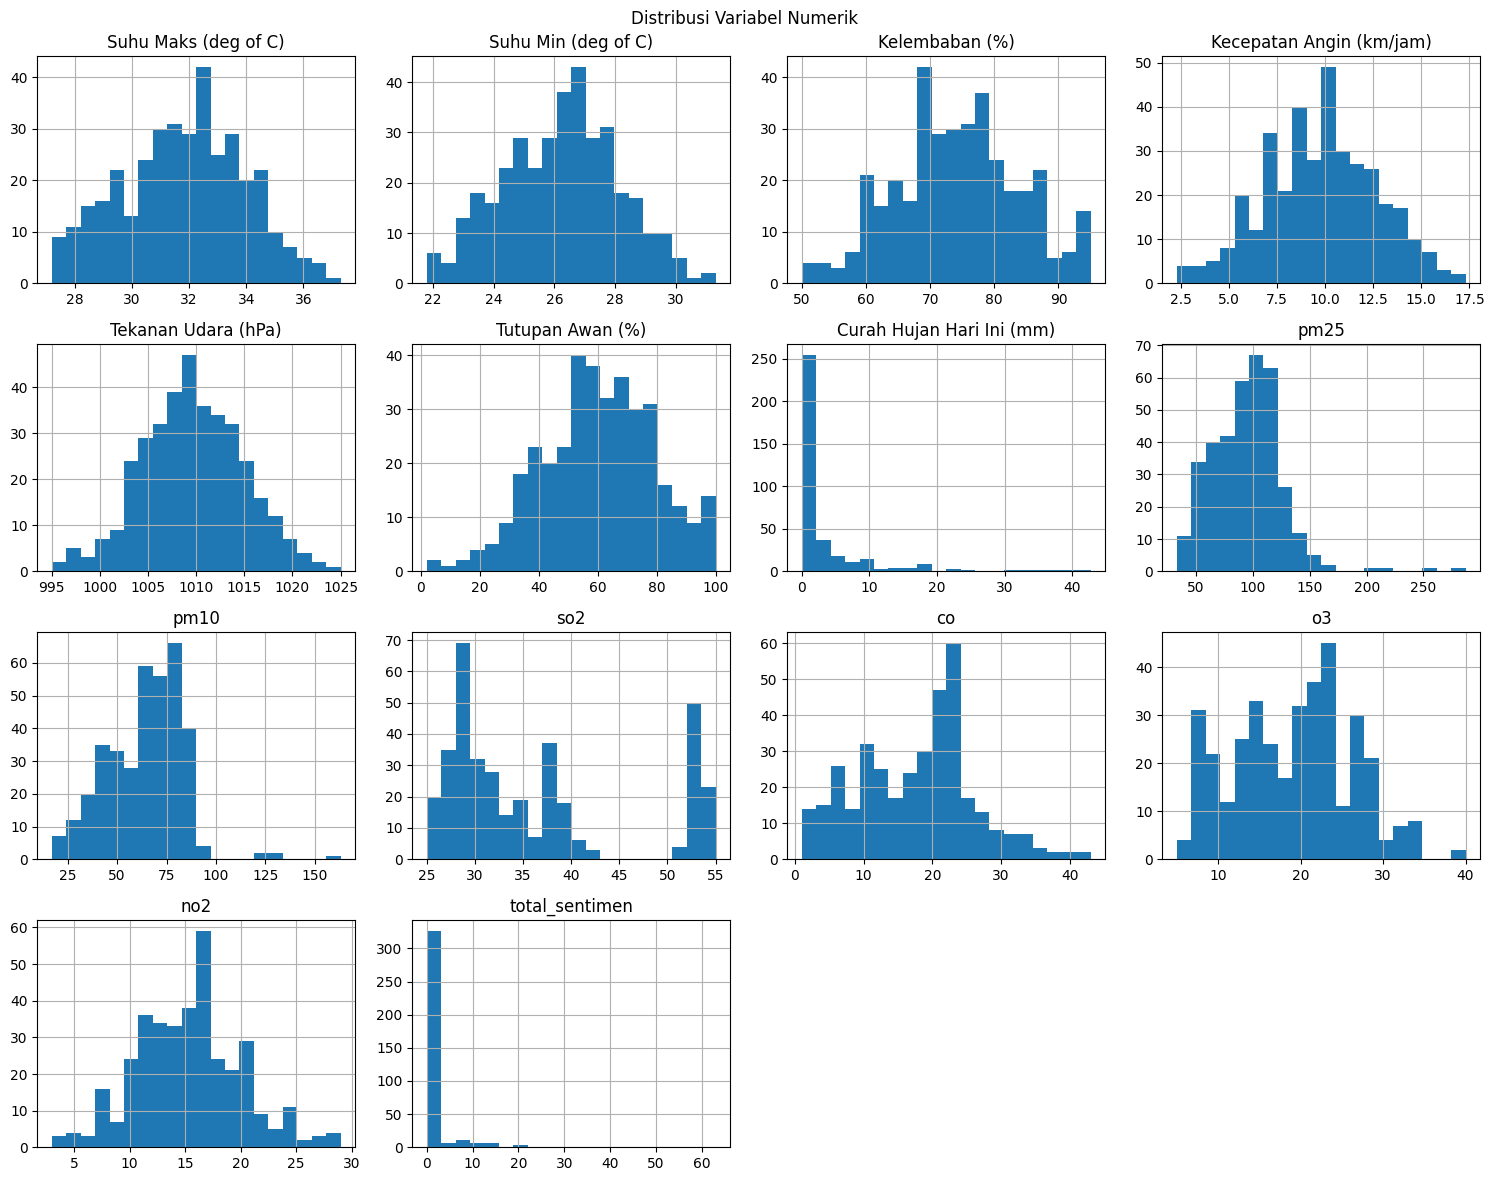

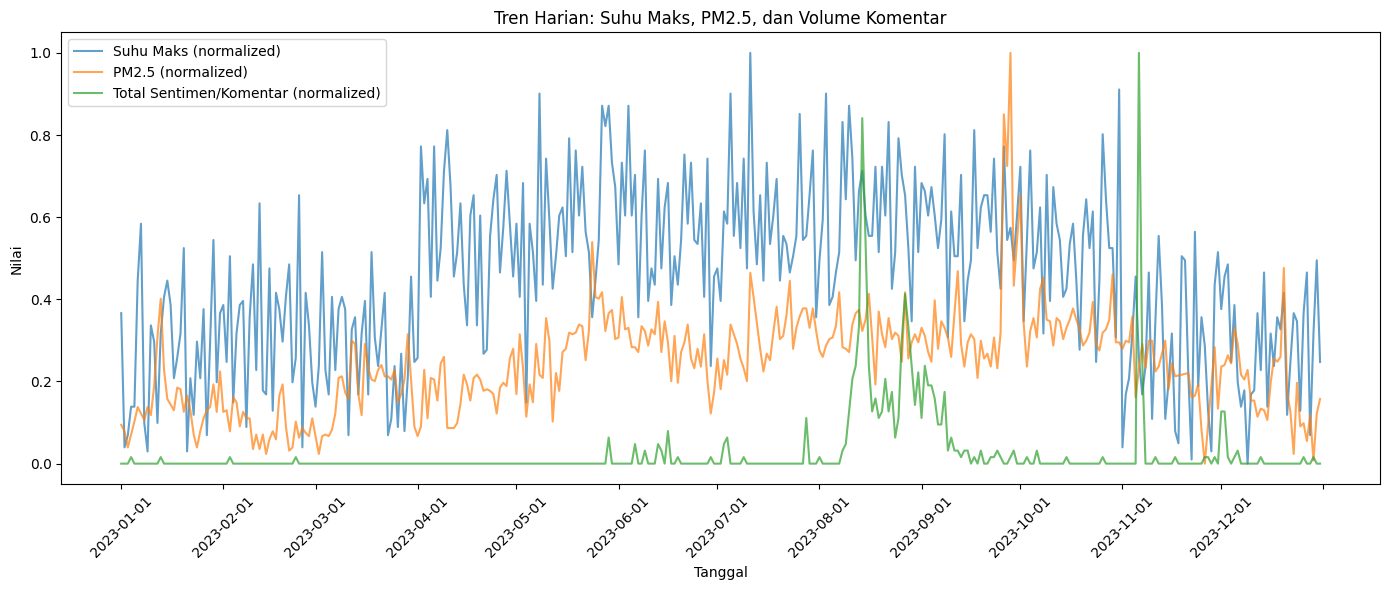

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import matplotlib.dates as mdates



df = pd.read_csv('integrasi_cuaca_udara_sentimen_2023.csv')

numeric_cols = [
    'Suhu Maks (deg of C)',
    'Suhu Min (deg of C)',
    'Kelembaban (%)',
    'Kecepatan Angin (km/jam)',
    'Tekanan Udara (hPa)',
    'Tutupan Awan (%)',
    'Curah Hujan Hari Ini (mm)',
    'pm25', 'pm10', 'so2', 'co', 'o3', 'no2',
    'total_sentimen'
]



display(df[numeric_cols].describe())

df[numeric_cols].hist(bins=20, figsize=(15, 12))
plt.suptitle('Distribusi Variabel Numerik')
plt.tight_layout()
plt.show()




plt.figure(figsize=(14, 6))

suhu_maks_norm = (df['Suhu Maks (deg of C)'] - df['Suhu Maks (deg of C)'].min()) / (df['Suhu Maks (deg of C)'].max() - df['Suhu Maks (deg of C)'].min())
pm25_norm = (df['pm25'] - df['pm25'].min()) / (df['pm25'].max() - df['pm25'].min())
total_sentimen_norm = (df['total_sentimen'] - df['total_sentimen'].min()) / (df['total_sentimen'].max() - df['total_sentimen'].min())

plt.plot(df['tanggal'], suhu_maks_norm, label='Suhu Maks (normalized)', alpha=0.7)
plt.plot(df['tanggal'], pm25_norm, label='PM2.5 (normalized)', alpha=0.7)
plt.plot(df['tanggal'], total_sentimen_norm, label='Total Sentimen/Komentar (normalized)', alpha=0.7)
plt.title('Tren Harian: Suhu Maks, PM2.5, dan Volume Komentar')
plt.xlabel('Tanggal')
plt.ylabel('Nilai')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # tiap minggu
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Outlier Suhu Maks:


,tanggal,Suhu Maks (deg of C)


Outlier Curah Hujan:


,tanggal,Curah Hujan Hari Ini (mm)
1,2023-01-02,15.1
2,2023-01-03,10.5
8,2023-01-09,13.0
9,2023-01-10,17.8
10,2023-01-11,17.8
11,2023-01-12,18.6
19,2023-01-20,18.2
29,2023-01-30,14.3
33,2023-02-03,10.1
37,2023-02-07,19.0


Outlier PM2.5:


,tanggal,pm25
268,2023-09-26,249.0
269,2023-09-27,217.0
270,2023-09-28,287.0
273,2023-10-01,199.0


Outlier Komentar/Sentimen:


,tanggal,total_sentimen
3,2023-01-04,1
12,2023-01-13,1
33,2023-02-03,1
53,2023-02-23,1
148,2023-05-29,4
...,...,...
338,2023-12-05,1
339,2023-12-06,2
346,2023-12-13,1
359,2023-12-26,1


Merge Outlier Sentimen dan Info Lingkungan:


,tanggal,Suhu Maks (deg of C)_x,Suhu Min (deg of C),Kelembaban (%),Kecepatan Angin (km/jam),Arah Angin (deg),Tekanan Udara (hPa),Tutupan Awan (%),Curah Hujan Hari Ini (mm)_x,Cuaca Hari Ini,Curah Hujan Besok (mm),Cuaca Besok,pm25_x,pm10,so2,co,o3,no2,categori,sentimen_1,sentimen_2,sentimen_3,sentimen_4,sentimen_5,sentimen_6,sentimen_7,sentimen_8,sentimen_9,sentimen_10,sentimen_11,sentimen_12,sentimen_13,sentimen_14,sentimen_15,sentimen_16,sentimen_17,sentimen_18,sentimen_19,sentimen_20,sentimen_21,sentimen_22,sentimen_23,sentimen_24,sentimen_25,sentimen_26,sentimen_27,sentimen_28,sentimen_29,sentimen_30,sentimen_31,sentimen_32,sentimen_33,sentimen_34,sentimen_35,sentimen_36,sentimen_37,sentimen_38,sentimen_39,sentimen_40,sentimen_41,sentimen_42,sentimen_43,sentimen_44,sentimen_45,sentimen_46,sentimen_47,sentimen_48,sentimen_49,sentimen_50,sentimen_51,sentimen_52,sentimen_53,sentimen_54,sentimen_55,sentimen_56,sentimen_57,sentimen_58,sentimen_59,sentimen_60,sentimen_61,sentimen_62,sentimen_63,total_sentimen,Suhu Maks (deg of C)_y,Curah Hujan Hari Ini (mm)_y,pm25_y
0,2023-01-04,28.6,24.1,53,6.7,0.7,1003.3,53,0.0,0,0.0,2,51.0,17.000000,53.0,4.0,9.0,10.0,2,"Hujan itu berkah, bukan musibah apalgi bencana...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,28.6,0.0,51.0
1,2023-01-13,30.4,25.8,68,2.3,358.0,1009.6,35,4.4,1,0.0,2,135.0,48.000000,55.0,15.0,28.0,15.0,1,Dan Akhirnya Panasss terik bak musim kemarau.....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,30.4,4.4,135.0
2,2023-02-03,32.3,27.0,93,11.9,146.0,1018.8,48,10.1,-1,0.5,1,53.0,40.000000,54.0,10.0,9.0,12.0,2,Mbak Nana maen ke Jambi dong mbak Nanan pengan...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,32.3,10.1,53.0
3,2023-02-23,29.8,25.4,77,7.0,14.7,1010.3,60,2.5,1,2.4,1,59.0,50.000000,27.0,11.0,8.0,14.0,2,Kredibel KLH di pertanyakan sebab hasil analis...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,29.8,2.5,59.0
4,2023-05-29,36.0,30.2,75,8.4,229.0,1009.6,27,0.0,2,0.0,0,126.0,69.507042,37.0,32.0,19.0,15.0,1,Sejak DKI Jakarta sudah tidak dijabat Anies Ba...,Pengusaha batu bara berhasil berada di posisi ...,Anis tuh yg bikin polusi,Udah kumuh busuk gak tertata rapi banyak sampa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,36.0,0.0,126.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,2023-12-05,31.1,26.8,76,12.4,55.2,1005.9,77,0.0,2,0.0,2,117.0,74.000000,52.0,9.0,21.0,13.0,1,"Mau komen apa ya, Mau bilang anies jelek tapi ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,31.1,0.0,117.0

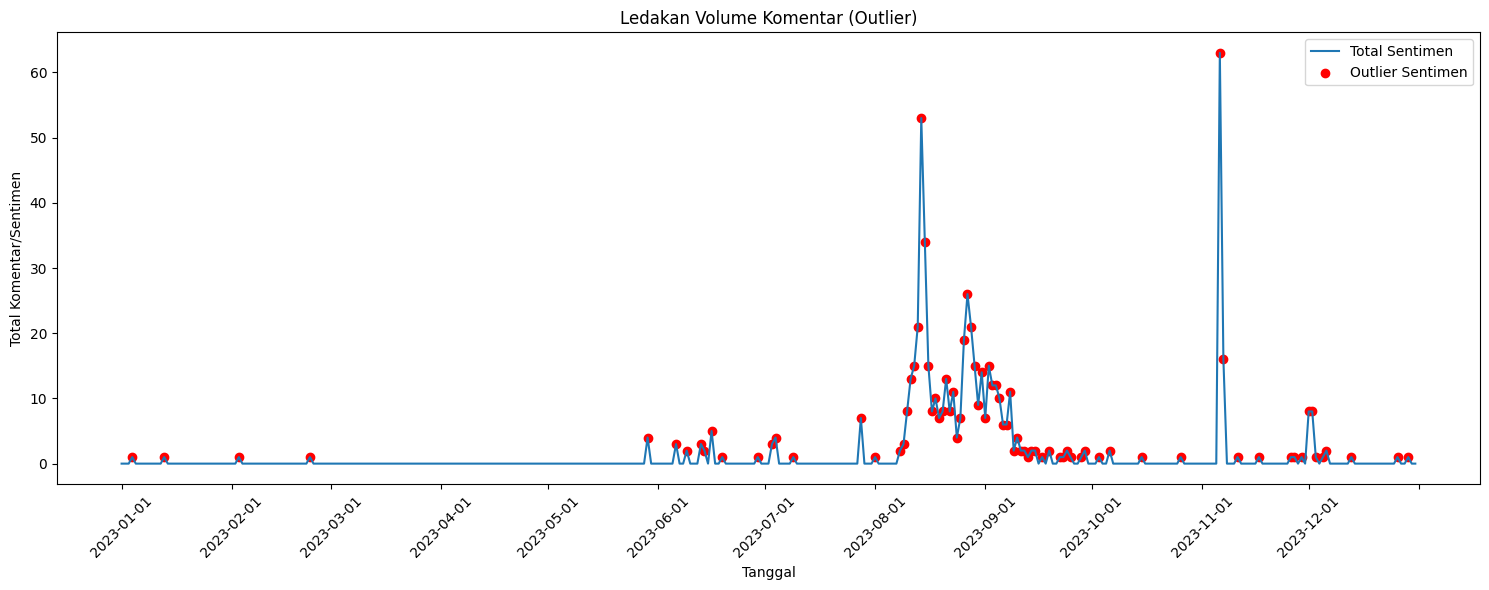

In [ ]:
def detect_outlier_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]


outlier_suhu = detect_outlier_iqr(df, 'Suhu Maks (deg of C)')
print("Outlier Suhu Maks:")
display(outlier_suhu[['tanggal', 'Suhu Maks (deg of C)']])


outlier_hujan = detect_outlier_iqr(df, 'Curah Hujan Hari Ini (mm)')
print("Outlier Curah Hujan:")
display(outlier_hujan[['tanggal', 'Curah Hujan Hari Ini (mm)']])


outlier_pm25 = detect_outlier_iqr(df, 'pm25')
print("Outlier PM2.5:")
display(outlier_pm25[['tanggal', 'pm25']])


outlier_sentimen = detect_outlier_iqr(df, 'total_sentimen')
print("Outlier Komentar/Sentimen:")
display(outlier_sentimen[['tanggal', 'total_sentimen']])

anomaly_merge = outlier_sentimen.merge(
    df[['tanggal', 'Suhu Maks (deg of C)', 'Curah Hujan Hari Ini (mm)', 'pm25']],
    on='tanggal', how='left'
)
print("Merge Outlier Sentimen dan Info Lingkungan:")
display(anomaly_merge)

plt.figure(figsize=(15, 6))
plt.plot(df['tanggal'], df['total_sentimen'], label='Total Sentimen')
plt.scatter(outlier_sentimen['tanggal'], outlier_sentimen['total_sentimen'], color='red', label='Outlier Sentimen')
plt.title('Ledakan Volume Komentar (Outlier)')
plt.ylabel('Total Komentar/Sentimen')
plt.xlabel('Tanggal')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # tiap minggu
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


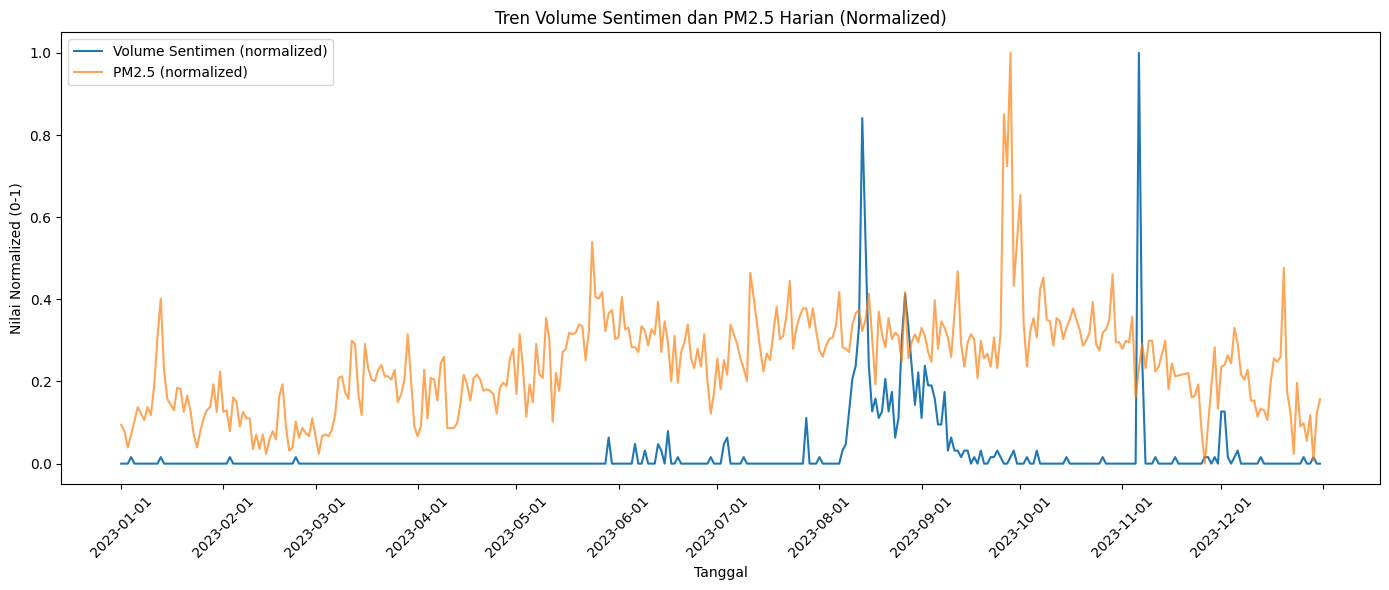

In [ ]:
plt.figure(figsize=(14,6))

sentimen_norm = (df['total_sentimen'] - df['total_sentimen'].min()) / (df['total_sentimen'].max() - df['total_sentimen'].min())
pm25_norm = (df['pm25'] - df['pm25'].min()) / (df['pm25'].max() - df['pm25'].min())

plt.plot(df['tanggal'], sentimen_norm, label='Volume Sentimen (normalized)')
plt.plot(df['tanggal'], pm25_norm, label='PM2.5 (normalized)', alpha=0.7)
plt.title('Tren Volume Sentimen dan PM2.5 Harian (Normalized)')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Normalized (0-1)')
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # tiap minggu
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

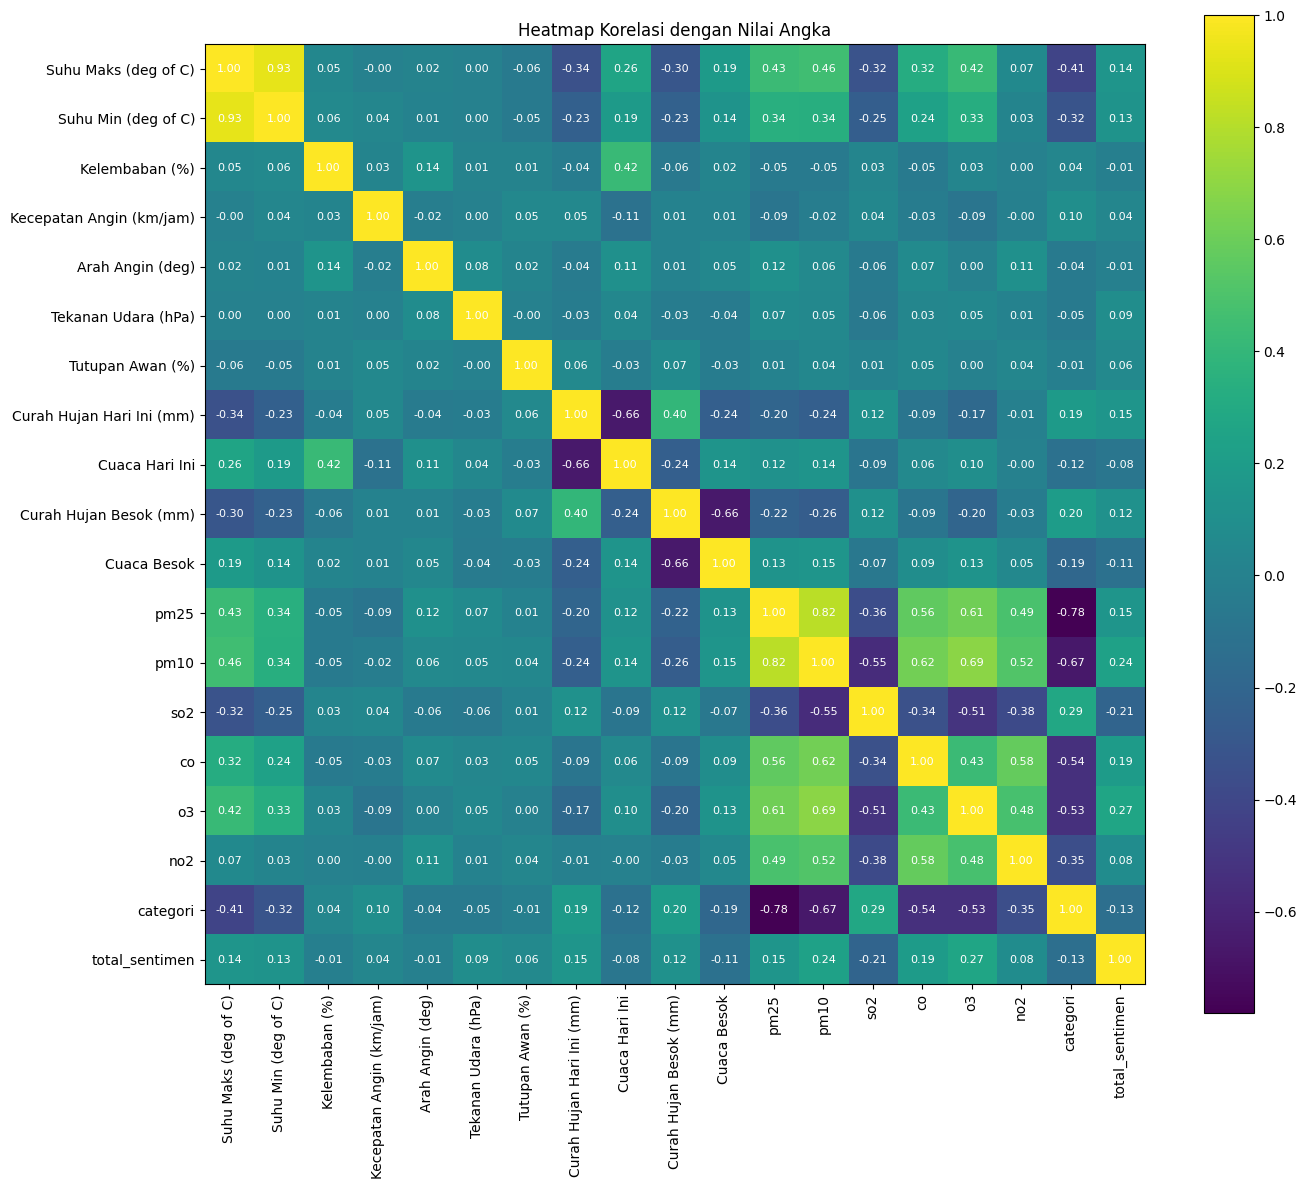

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df_final = pd.read_csv('integrasi_cuaca_udara_sentimen_2023.csv')  # Ganti dengan nama file aslinya


kolom_numerik = df_final.select_dtypes(include="number")
corr = kolom_numerik.corr()


plt.figure(figsize=(14, 12))
plt.imshow(corr, cmap="viridis")
plt.colorbar()

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Heatmap Korelasi dengan Nilai Angka")

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        value = corr.iloc[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='white', fontsize=8)

plt.tight_layout()
plt.show()


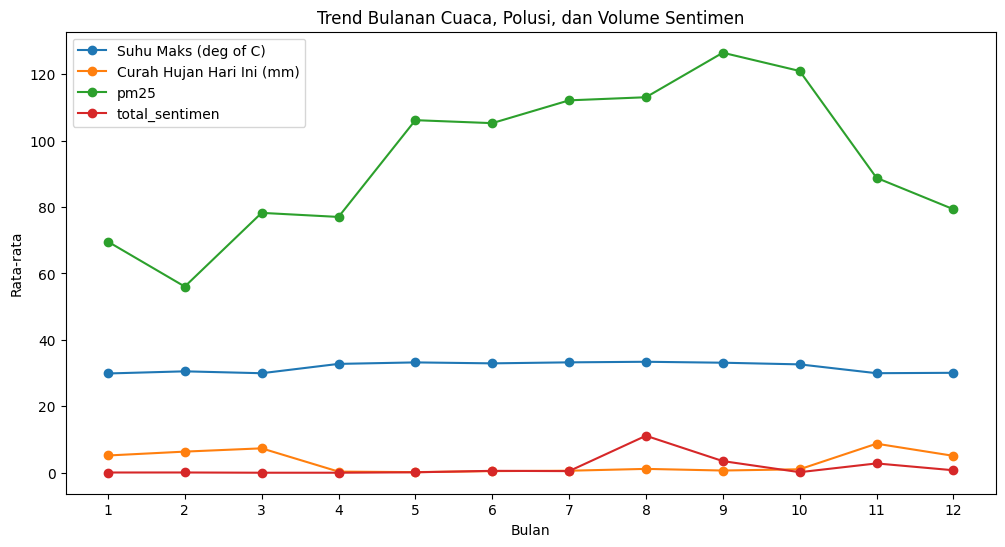

C:\Users\Bima Sena\AppData\Local\Temp\ipykernel_20288\3726694658.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bulan', y=col, data=df, palette='tab20')
C:\Users\Bima Sena\AppData\Local\Temp\ipykernel_20288\3726694658.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bulan', y=col, data=df, palette='tab20')
C:\Users\Bima Sena\AppData\Local\Temp\ipykernel_20288\3726694658.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bulan', y=col, data=df, palette='tab20')
C:\Users\Bima Sena\AppData\Local\Temp\ipykernel_20288\3726694

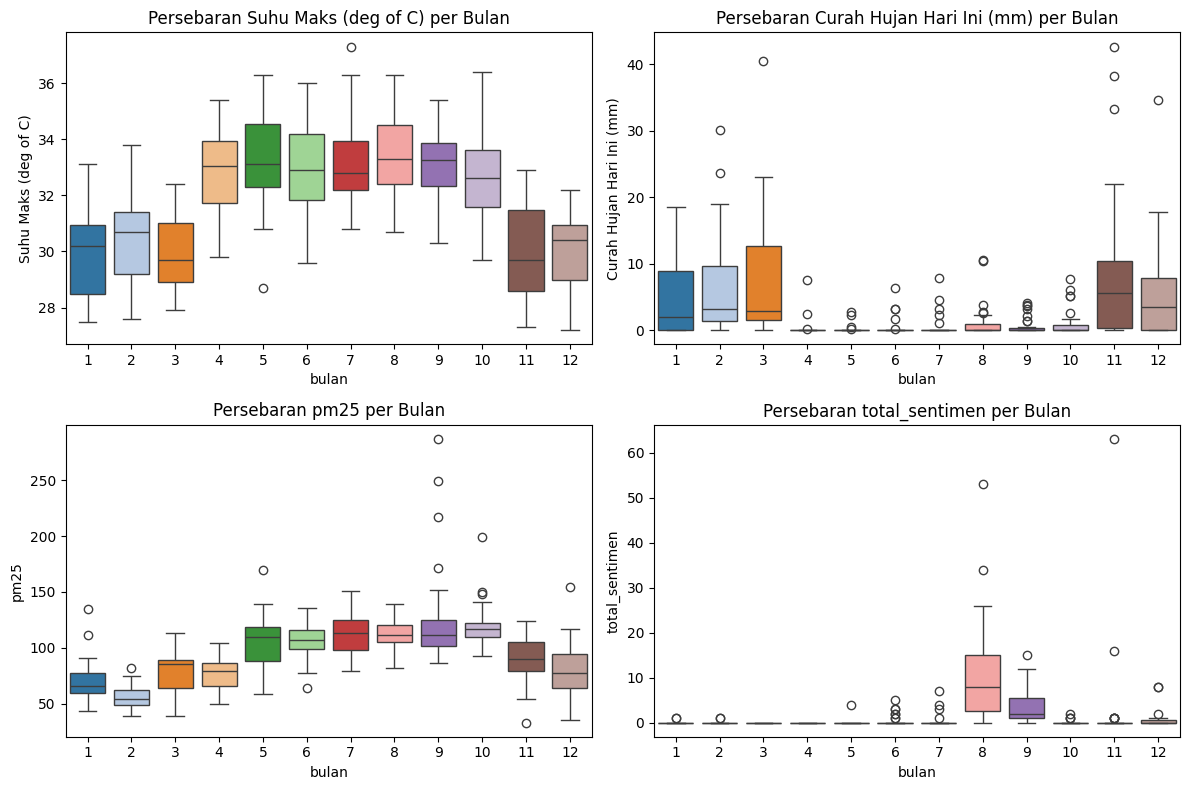

Statistik Bulanan:
       Suhu Maks (deg of C)  Curah Hujan Hari Ini (mm)        pm25  \
bulan                                                                
1                 29.877419                   5.187097   69.564516   
2                 30.521429                   6.353571   56.035714   
3                 29.951613                   7.341935   78.225806   
4                 32.760000                   0.336667   77.000000   
5                 33.209677                   0.177419  106.129032   
6                 32.923333                   0.486667  105.233333   
7                 33.225806                   0.600000  112.096774   
8                 33.400000                   1.154839  113.032258   
9                 33.116667                   0.660000  126.433333   
10                32.616129                   1.038710  120.935484   
11                29.960000                   8.736667   88.766667   
12                30.077419                   5.083871   79.322581   



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df['tanggal'] = pd.to_datetime(df['tanggal'])
df['bulan'] = df['tanggal'].dt.month


fitur = ['Suhu Maks (deg of C)', 'Curah Hujan Hari Ini (mm)', 'pm25', 'total_sentimen']

# (rata-rata per bulan)
bulanan = df.groupby('bulan')[fitur].mean()


plt.figure(figsize=(12, 6))
for col in fitur:
    plt.plot(bulanan.index, bulanan[col], marker='o', label=col)
plt.legend()
plt.title('Trend Bulanan Cuaca, Polusi, dan Volume Sentimen')
plt.xlabel('Bulan')
plt.ylabel('Rata-rata')
plt.xticks(range(1,13))
plt.show()


import seaborn as sns
plt.figure(figsize=(12,8))
for i, col in enumerate(fitur, 1):
    plt.subplot(2,2,i)
    sns.boxplot(x='bulan', y=col, data=df, palette='tab20')
    plt.title(f'Persebaran {col} per Bulan')
plt.tight_layout()
plt.show()


print("Statistik Bulanan:")
print(bulanan)

# Jika ingin analisis musiman (berdasarkan aturan lokal), misal musim hujan (Nov-Apr), kemarau (Mei-Okt):
df['musim'] = df['bulan'].apply(lambda x: 'Hujan' if x in [11,12,1,2,3,4] else 'Kemarau')
musiman = df.groupby('musim')[fitur].mean()
print("\nStatistik Musiman:")
print(musiman)


In [ ]:

kolom_numerik.max()


Suhu Maks (deg of C)           37.3
Suhu Min (deg of C)            31.3
Kelembaban (%)                 95.0
Kecepatan Angin (km/jam)       17.3
Arah Angin (deg)              359.1
Tekanan Udara (hPa)          1025.0
Tutupan Awan (%)              100.0
Curah Hujan Hari Ini (mm)      42.7
Cuaca Hari Ini                  2.0
Curah Hujan Besok (mm)         42.7
Cuaca Besok                     2.0
pm25                          287.0
pm10                          163.0
so2                            55.0
co                             43.0
o3                             40.0
no2                            29.0
categori                        3.0
total_sentimen                 63.0
dtype: float64